In [30]:
import torch
from torchmetrics.classification import Accuracy
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary

In [31]:
# Set device to gpu if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Continue training from saved model point?
continue_train = False

# file paths
dataset_path = './datasets/'
net_pt = './models/EMNIST-Conv2d-net.pt'

# model parameters
n_epochs = 3
batch_size = 32
learning_rate = 0.0005
momentum = 0.9

In [32]:
# log writer for tensorboard
writer = SummaryWriter('./logs/EMNIST-Conv2d')

# seed used by PyTorch for repeatable testing
random_seed = 1
torch.manual_seed(random_seed)

# EMNIST classes
classes = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']

In [33]:
# transformers for datasets
# training set will get additional data augmentation for better training diversity
train_transform = torchvision.transforms.Compose([
                    torchvision.transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(
                        (0.1307,),(0.3081,))
                ])

test_transform = torchvision.transforms.Compose([ 
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(
                        (0.1307,),(0.3081,))
                ])

# load datasets
train_dataset = torchvision.datasets.EMNIST(
                    dataset_path,
                    split = 'balanced',
                    train = True,
                    download = True,
                    transform = train_transform)

test_dataset = torchvision.datasets.EMNIST(
                    dataset_path,
                    split = 'balanced',
                    train = False,
                    download = True,
                    transform = test_transform)

In [34]:
# wrap datasets in DataLoaders
def get_data(train_dataset, test_dataset, batch_size):
    return (
        torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
        torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    )

In [35]:
train_ld, _ = get_data(train_dataset, test_dataset, batch_size)

dataiter = iter(train_ld)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32])


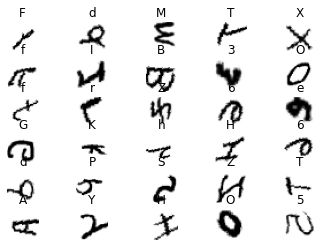

In [36]:
# view sample of images and corresponding labels from batch
figure = plt.figure()
num_of_images = 30
for i in range(1, 31):
    plt.subplot(6, 5, i)
    plt.axis('off')
    plt.imshow(images[i].numpy().squeeze(), cmap='gray_r')
    plt.title(classes[labels[i].item()])

In [37]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 50, kernel_size=3, padding='same'),
            nn.LeakyReLU(),
            nn.Dropout2d(p=0.1),
            nn.MaxPool2d(kernel_size=2, stride=None),
            nn.BatchNorm2d(50)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(50, 50, kernel_size=3, padding='same'),
            nn.LeakyReLU(),
            nn.Dropout2d(p=0.1),
            nn.MaxPool2d(kernel_size=2, stride=None),
            nn.BatchNorm2d(50)  
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(50, 100, kernel_size=5, padding='same'),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.linear1 = nn.Sequential(
            nn.Linear(100*9, 100),
            nn.LeakyReLU(),
            nn.Dropout(p=0.4)
        )
        self.linear2 = nn.Linear(100, 47)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [38]:
summary(Net(), (32, 1, 28, 28), col_names=['input_size', 'output_size', 'kernel_size'], col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Kernel Shape
Net                                      --                   --                   --
├─Sequential: 1-1                        [32, 1, 28, 28]      [32, 50, 14, 14]     --
│    └─Conv2d: 2-1                       [32, 1, 28, 28]      [32, 50, 28, 28]     [1, 50, 3, 3]
│    └─LeakyReLU: 2-2                    [32, 50, 28, 28]     [32, 50, 28, 28]     --
│    └─Dropout2d: 2-3                    [32, 50, 28, 28]     [32, 50, 28, 28]     --
│    └─MaxPool2d: 2-4                    [32, 50, 28, 28]     [32, 50, 14, 14]     --
│    └─BatchNorm2d: 2-5                  [32, 50, 14, 14]     [32, 50, 14, 14]     [50]
├─Sequential: 1-2                        [32, 50, 14, 14]     [32, 50, 7, 7]       --
│    └─Conv2d: 2-6                       [32, 50, 14, 14]     [32, 50, 14, 14]     [50, 50, 3, 3]
│    └─LeakyReLU: 2-7                    [32, 50, 14, 14]     [32, 50, 14, 14]     --
│    └─Dropout2d: 2

In [39]:
class WrappedDataLoader:
    def __init__(self, data_loader):
        self.data_loader = data_loader
        self.dataset = data_loader.dataset
    
    def __len__(self):
        return len(self.data_loader)
    
    def __iter__(self):
        batches = iter(self.data_loader)
        for batch in batches:
            yield (self.preprocess(*batch))
            
    def preprocess(self, data, labels):
        return data.view(-1, 1, 28, 28).to(device), labels.to(device)

In [40]:
# loads new or trained model and optimizer
def get_model():
    model = Net()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    return model, optimizer

def loss_batch(preds, labels, opt=None):
    loss = F.cross_entropy(preds, labels, reduction='mean')
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item()

In [41]:
train_losses = []
test_losses = []

In [42]:
def train(model, epochs, train_loader, test_loader, opt):
    scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.5)
    
    train_accuracy = Accuracy().to(device)
    
    for epoch in range(1, epochs+1):        
        model.train()
        correct = 0
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            preds = model(images)
            loss = loss_batch(preds, labels, opt)
            
            pred = preds.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).sum()
            
            train_accuracy.update(preds, labels)
            running_loss += loss
            train_losses.append(loss)
            
            if i % 1000 == 0:
                progress_pct = round(100. * i / len(train_loader))
                print(f'Train Epoch: {epoch} ({progress_pct}%)\tLoss: {round(loss, 4)}')
        
        total_train_accuracy = round(float(train_accuracy.compute()*100), 2)
        running_loss /= len(train_loader)
        
        writer.add_scalar('Accuracy/train', total_train_accuracy, epoch)
        #writer.add_scalar('Loss/train', running_loss, epoch)
        
        print(f'\nTrain set: \tAvg. loss: {round(running_loss, 4)} \tAccuracy: {correct}/{len(train_loader.dataset)} ({total_train_accuracy}%)')
        
        train_accuracy.reset()
        running_loss = 0.0
        
        test(epoch, model, test_loader)
        
        if epoch is not epochs:
            scheduler.step()
            
        torch.save(model, net_pt)
    
    return model

In [43]:
def test(epoch, model, test_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    
    test_accuracy = Accuracy().to(device)
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            preds = model(images)
            loss = loss_batch(preds, labels)
            
            pred = preds.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).sum()
            
            test_accuracy.update(preds, labels)
            running_loss += loss
            test_losses.append(loss)
                
    total_test_accuracy = round(float(test_accuracy.compute() * 100), 2)
    running_loss /= len(test_loader)
    
    writer.add_scalar('Accuracy/test', total_test_accuracy, epoch)
    #writer.add_scalar('Loss/test', running_loss, epoch)
    
    print(f'Test set: \tAvg. loss: {round(running_loss, 4)} \tAccuracy: {correct}/{len(test_loader.dataset)} ({total_test_accuracy}%)\n')
    
    test_accuracy.reset()

In [44]:
train_loader, test_loader = get_data(train_dataset, test_dataset, batch_size)
train_loader = WrappedDataLoader(train_loader)
test_loader = WrappedDataLoader(test_loader)
model, opt = get_model()

model = train(model, n_epochs, train_loader, test_loader, opt)

Train Epoch: 1 (0%)	Loss: 3.8545
Train Epoch: 1 (28%)	Loss: 1.0553
Train Epoch: 1 (57%)	Loss: 0.9651
Train Epoch: 1 (85%)	Loss: 0.5719

Train set: 	Avg. loss: 1.1982 	Accuracy: 71534/112800 (63.42%)
Test set: 	Avg. loss: 0.4462 	Accuracy: 15931/18800 (84.74%)

Train Epoch: 2 (0%)	Loss: 0.7548
Train Epoch: 2 (28%)	Loss: 0.4465
Train Epoch: 2 (57%)	Loss: 0.4721
Train Epoch: 2 (85%)	Loss: 0.5776

Train set: 	Avg. loss: 0.6311 	Accuracy: 89335/112800 (79.2%)
Test set: 	Avg. loss: 0.3849 	Accuracy: 16284/18800 (86.62%)

Train Epoch: 3 (0%)	Loss: 0.7115
Train Epoch: 3 (28%)	Loss: 0.5076
Train Epoch: 3 (57%)	Loss: 0.3999
Train Epoch: 3 (85%)	Loss: 0.58

Train set: 	Avg. loss: 0.5448 	Accuracy: 92401/112800 (81.92%)
Test set: 	Avg. loss: 0.3626 	Accuracy: 16485/18800 (87.69%)



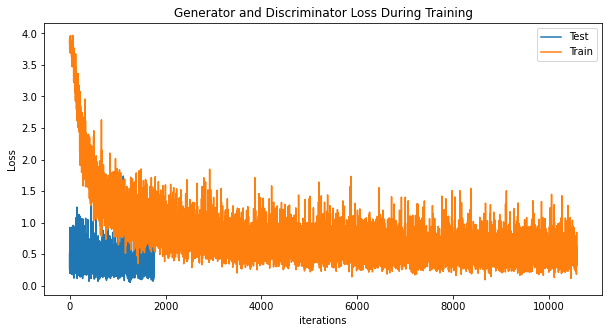

In [45]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(test_losses,label="Test")
plt.plot(train_losses,label="Train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()